# Collect & plot results of parallellized ISRSA

In [1]:
%matplotlib inline
import os, glob, warnings, sys
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.mask import expand_mask, collapse_mask
import scipy.stats as ss
from scipy.stats import pearsonr,spearmanr
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection/'

## Load parcellation

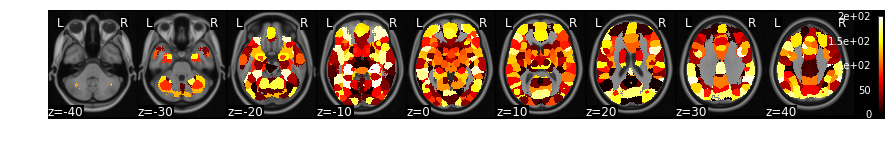

In [2]:
nparcel = 200
roi = Brain_Data(os.path.join(base_dir,
      'Data/6.Parcellation/whole_brain_cluster_labels_PCA=100_k=%s.nii.gz' % nparcel))
roi.plot()
roi_x = expand_mask(roi)

## Collect results

X4


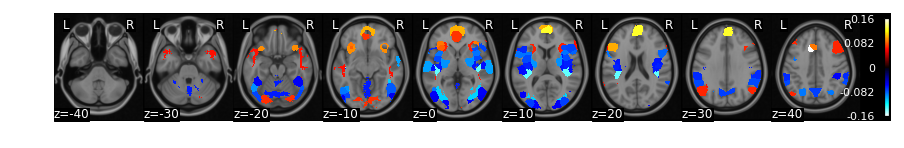

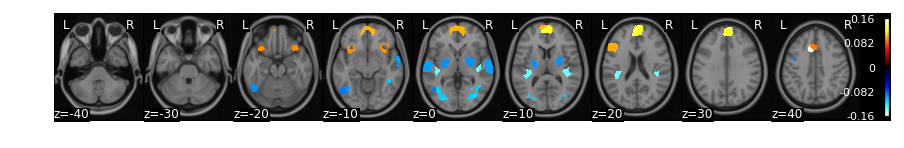

In [170]:
screen = 'Dec'
thresh = 0.05
permutation_method = 'vector'
conds = ['X4',]

for cond in conds:
    print cond

    roi_r = roi.copy()
    roi_p = roi.copy()

    results_allparcels = pd.DataFrame()
    for parcel in range(nparcel):
        parcelDat = pd.read_csv(os.path.join(base_dir,
           'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s/parcel%03d.csv'%(
            nparcel,permutation_method,screen,cond,parcel)),index_col=0)
        results_allparcels = results_allparcels.append(parcelDat,ignore_index=True)
        roi_r.data[roi_x[parcel].data>0] = float(parcelDat['r'])*1000000
        roi_p.data[roi_x[parcel].data>0] = float(parcelDat['p'])*1000000
    results_allparcels.to_csv(os.path.join(base_dir,
               'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
            nparcel,permutation_method,screen,cond),'allparcels.csv'))
    roi_r.data = roi_r.data.astype(float)/1000000
    roi_p.data = roi_p.data.astype(float)/1000000
#         roi_r.plot()
#         roi_p.plot()
    roi_r.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R.nii.gz' % (
            nparcel,permutation_method,screen,cond)))
    roi_p.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_P.nii.gz' % (
            nparcel,permutation_method,screen,cond)))

    fdr_thresh = fdr(np.array(results_allparcels['p']),thresh)
    bonf_thresh = thresh/nparcel
    threshs_all = {'bonf':bonf_thresh,'fdr':fdr_thresh}
    for thresh_type in threshs_all:
        roi_r_thr = threshold(stat=roi_r,p=roi_p,thr=threshs_all[thresh_type])
        roi_r_thr.plot()

        plt.savefig(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.png' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))
        plt.show()
        roi_r_thr.write(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s.nii.gz' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))
        
        roi_r_thr_posOnly = roi_r_thr.copy()
        roi_r_thr_posOnly.data[roi_r_thr_posOnly.data<0] = 0
        roi_r_thr_posOnly.write(os.path.join(base_dir,
             'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s-posOnly.nii.gz' % (
                nparcel,permutation_method,screen,cond,thresh,thresh_type)))

In [4]:
# How many significant effects?
import nltools;

# screen = 'Dec'
sampleChoice = 'full'
groupExclude = 'none'#,'GR','GA','IA','MO']
thresh = 0.05
nparcel = 200
thresh_type = 'bonf'
permutation_method = 'vector'
cond = 'X4'

results = pd.read_csv(os.path.join(base_dir,
   'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
    nparcel,permutation_method,screen,cond),'allparcels.csv'),
                     index_col=0)

if thresh_type == 'fdr':
    results['sig'] = results['p']<=(fdr(np.array(results['p']),0.05))
elif thresh_type == 'bonf':
    results['sig'] = results['p']<=(0.05/nparcel)

results['sig_pos'] = np.multiply(results['sig'],results['r']>0)

results.sig_pos.sum()

7

## Collect results ('Face' and 'Inv' screens)

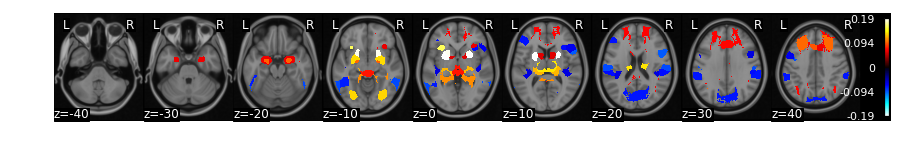

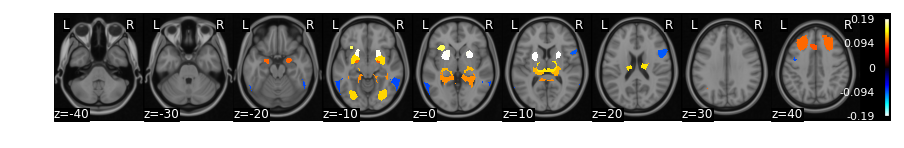

In [174]:
screen = 'Inv'
thresh = 0.05
permutation_method = 'vector'

roi_r = roi.copy()
roi_p = roi.copy()

results_allparcels = pd.DataFrame()
for parcel in range(nparcel):
    parcelDat = pd.read_csv(os.path.join(base_dir,
       'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s/parcel%03d.csv'%(
        nparcel,permutation_method,screen,parcel)),index_col=0)
    results_allparcels = results_allparcels.append(parcelDat,ignore_index=True)
    roi_r.data[roi_x[parcel].data>0] = float(parcelDat['r'])*1000000
    roi_p.data[roi_x[parcel].data>0] = float(parcelDat['p'])*1000000
results_allparcels.to_csv(os.path.join(base_dir,
           'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s'%(
        nparcel,permutation_method,screen),'allparcels.csv'))
roi_r.data = roi_r.data.astype(float)/1000000
roi_p.data = roi_p.data.astype(float)/1000000
#         roi_r.plot()
#         roi_p.plot()
roi_r.write(os.path.join(base_dir,
     'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s_R.nii.gz' % (
        nparcel,permutation_method,screen)))
roi_p.write(os.path.join(base_dir,
     'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s_P.nii.gz' % (
        nparcel,permutation_method,screen)))

fdr_thresh = fdr(np.array(results_allparcels['p']),thresh)
bonf_thresh = thresh/nparcel
threshs_all = {'bonf':bonf_thresh,'fdr':fdr_thresh}
for thresh_type in threshs_all:
    roi_r_thr = threshold(stat=roi_r,p=roi_p,thr=threshs_all[thresh_type])
    roi_r_thr.plot()

    plt.savefig(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s.png' % (
            nparcel,permutation_method,screen,thresh,thresh_type)))
    plt.show()
    roi_r_thr.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s.nii.gz' % (
            nparcel,permutation_method,screen,thresh,thresh_type)))
    roi_r_thr_posOnly = roi_r_thr.copy()
    roi_r_thr_posOnly.data[roi_r_thr_posOnly.data<0] = 0
    roi_r_thr_posOnly.write(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s-posOnly.nii.gz' % (
            nparcel,permutation_method,screen,thresh,thresh_type)))

In [16]:
# How many significant effects?
import nltools;
# sampleChoice = 'full'
# groupExclude = 'none'#,'GR','GA','IA','MO']
thresh = 0.05
nparcel = 200
thresh_type = 'bonf'
permutation_method = 'vector'
cond = 'X4'

results = pd.read_csv(os.path.join(base_dir,
   'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s'%(
    nparcel,permutation_method,screen),'allparcels.csv'),
                     index_col=0)

if thresh_type == 'fdr':
    results['sig'] = results['p']<=(fdr(np.array(results['p']),0.05))
elif thresh_type == 'bonf':
    results['sig'] = results['p']<=(0.05/nparcel)

results['sig_pos'] = np.multiply(results['sig'],results['r']>0)

results.sig_pos.sum()

6

#### Compare screens

In [97]:
screens = ['Face','Inv','Mult','Dec']
thresh = 0.05
nparcel = 200
thresh_type = 'bonf'
permutation_method = 'vector'
cond = 'X4'

n_sig_df = pd.DataFrame(columns=['Screen','SigParcels'])
for si,screen in enumerate(screens):
    if (si>1) & (si<4): #For Mult and Dec
        results = pd.read_csv(os.path.join(base_dir,
           'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
            nparcel,permutation_method,screen,cond),'allparcels.csv'),
                             index_col=0)
    else:
        results = pd.read_csv(os.path.join(base_dir,
           'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s'%(
            nparcel,permutation_method,screen),'allparcels.csv'),
                             index_col=0)
    if thresh_type == 'fdr':
        results['sig'] = results['p']<=(fdr(np.array(results['p']),0.05))
    elif thresh_type == 'bonf':
        results['sig'] = results['p']<=(0.05/nparcel)
    results['sig_pos'] = np.multiply(results['sig'],results['r']>0)
    n_sig = results.sig_pos.sum()
    n_sig_df = n_sig_df.append(pd.DataFrame([[screen,n_sig]],columns=n_sig_df.columns))
n_sig_df = n_sig_df.reset_index(drop=True)

In [98]:
n_sig_df

,Screen,SigParcels
0,Face,2
1,Inv,11
2,Mult,27
3,Dec,7


Text(0.5,1,'ISRSA effects per task screen')

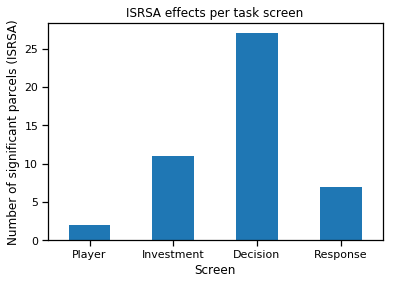

In [99]:
sns.set_context('notebook')
ax = n_sig_df.plot(kind='bar',x='Screen',y='SigParcels',legend=False,
                   color=sns.color_palette('tab10',1))
ax.set_xticklabels(['Player','Investment','Decision','Response'],rotation=0);
# plt.legend(['Number of parcels\nwith significant\nISRSA effect']);
ax.set_ylabel('Number of significant parcels (ISRSA)');
ax.set_title('ISRSA effects per task screen')

#### Generate supp fig 7

In [3]:
from nilearn.plotting import plot_stat_map
screens = ['Face','Inv','Mult','Dec']
paperNames = ['Player','Investment','Decision','Response']
nparcel = 200
permutation_method = 'vector'
cond = 'X4'
from numpy.polynomial.polynomial import polyfit
thresh = 0.05
thresh_type = 'bonf'

all_r = pd.DataFrame(columns=['Screen','Parcel','r','p'])
for si,screen in enumerate(screens):
    cond = 'X4' if (si>1) & (si<4) else ''
    results = pd.read_csv(os.path.join(base_dir,
       'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
        nparcel,permutation_method,screen,cond),'allparcels.csv'),
                         index_col=0)
    results['Screen'] = screen
    results['Parcel'] = range(nparcel)
    all_r = all_r.append(results)
#     results['r']

/home/decision/jervbaa/.conda/envs/hmtg_fmri_nc/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
r_thresh = np.sort(all_r.loc[(all_r['p']<(0.05/200)) & (all_r['r']>0),'r'].values)[0]
min_r = np.min(all_r['r'])
max_r = np.max(all_r['r'])
print(min_r,max_r)
xlims = [-.15,.2]
bins = np.arange(-.15,.2,.01)
print(len(bins))

(-0.13829451859401393, 0.1880964111784832)
35


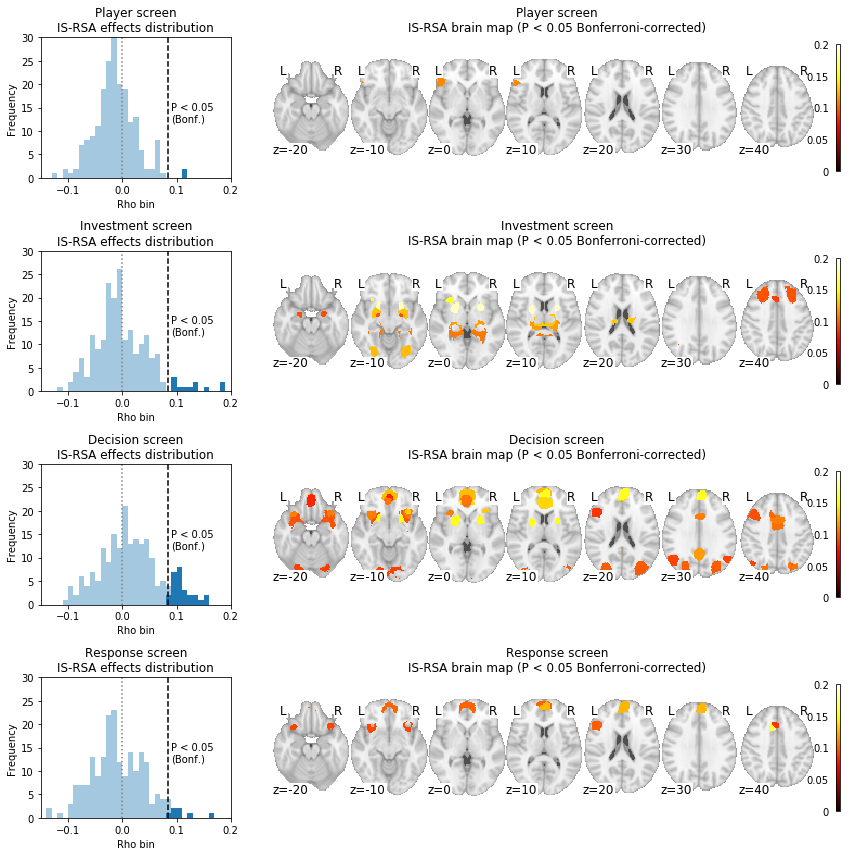

In [5]:
fig,ax = plt.subplots(4,2,figsize=[12,12],gridspec_kw={'width_ratios':[1,3]})

screens = ['Face','Inv','Mult','Dec']
paperNames = ['Player','Investment','Decision','Response']
nparcel = 200
permutation_method = 'vector'
cond = 'X4'
from numpy.polynomial.polynomial import polyfit
thresh = 0.05
thresh_type = 'bonf'

map_sim_df = pd.DataFrame(columns=['Screen','ISRSA_corr'])
for si,screen in enumerate(screens):
    cond = 'X4' if (si>1) & (si<4) else ''
    results = pd.read_csv(os.path.join(base_dir,
       'Results/3.fMRI-ISRSA/IS-RSA/IS-RSA_nparcel-%i_perm-%s_%s%s'%(
        nparcel,permutation_method,screen,cond),'allparcels.csv'),
                         index_col=0)
    ISRSA_currentScreen = results['r']
    sns.distplot(ISRSA_currentScreen,kde=False,ax=ax[si,0],bins=bins)
    sig_r = results.loc[(results['p']<0.05/200) & (results['r']>0),'r']
    ax[si,0].hist(sig_r,bins=bins,color=sns.color_palette('tab10',1))
    ax[si,0].plot([0,0],[0,50],':',color=[.5,.5,.5])
    ax[si,0].plot([r_thresh,r_thresh],[0,50],'k--')
    ax[si,0].set(title='%s screen\nIS-RSA effects distribution'%paperNames[si],xlabel='Rho bin',
              ylabel='Frequency',xlim=xlims,ylim=[0,30])
#     ax[si,0].text(0.09,12,'P < 0.05\n(Bonf.)\nn(sig.) = %i'%len(sig_r))
    ax[si,0].text(0.09,12,'P < 0.05\n(Bonf.)')
    
plt.tight_layout();
for si,screen in enumerate(screens):
    cond = 'X4' if (si>1) & (si<4) else ''
    plot_stat_map(os.path.join(base_dir,
         'Results/3.fMRI-ISRSA/IS-RSA/Maps/Maps_nparcel-%i_perm-%s/%s%s_R-thr-%.2f-%s-posOnly.nii.gz' % (
            nparcel,permutation_method,screen,cond,thresh,thresh_type)),axes=ax[si,1],
              display_mode='z',cut_coords=[-20,-10,0,10,20,30,40],vmax=.2,)
    ax[si,1].set(title='%s screen\nIS-RSA brain map (P < 0.05 Bonferroni-corrected)'%paperNames[si])
map_sim_df = map_sim_df.reset_index(drop=True)
plt.savefig(os.path.join(base_dir,'Results/3.fMRI-ISRSA/IS-RSA/Maps/ScreenCompare.pdf'))